In [2]:
import numpy as np
import scprep
import matplotlib.pyplot as plt
import scanpy as sc
import pickle
import pathlib
import seaborn as sns
import pandas as pd

In [3]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
res_dir = '../results_final_Dec22/'

In [4]:
traj = np.load(f'{res_dir}/trajectories.npy')

In [5]:
with open(f'{res_dir}scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
X_phate = scaler.transform(adata.obsm['X_phate'])

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/tmp/ipykernel_989095/183052393.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_phate[:,0], X_phate[:,1], c='gray', cmap='viridis')


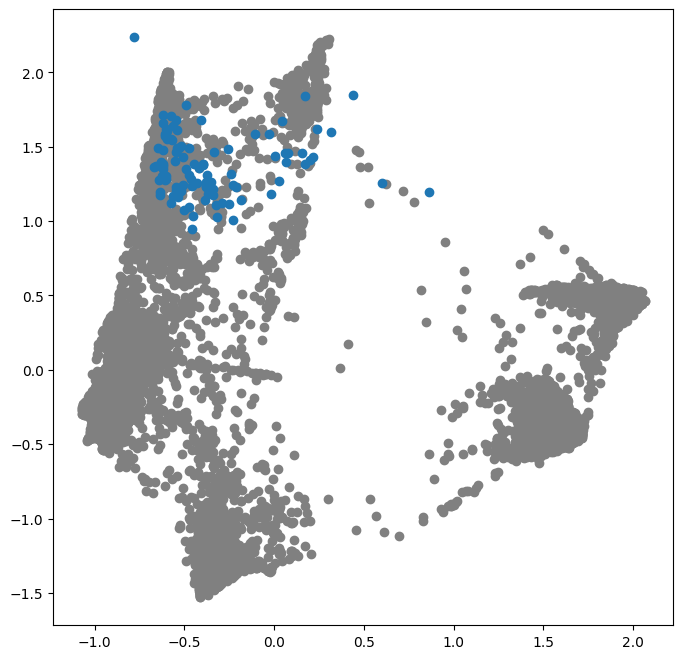

In [6]:
last_pt = traj[-1,...]
plt.figure(figsize=(8,8))
plt.scatter(X_phate[:,0], X_phate[:,1], c='gray', cmap='viridis')
plt.scatter(last_pt[:,0], last_pt[:,1])

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


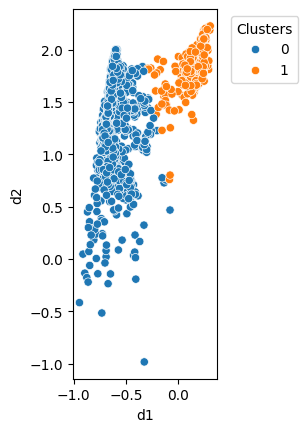

In [7]:
# cluster "starting" points and annotate trajectories
np.random.seed(32)
# t0_df = df[df['samples'] == 3].copy()
t0_df = pd.DataFrame(adata[adata.obs['day'] == adata.obs['day'].max()].obsm['X_phate'], columns=['d1', 'd2'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
t0_df['cluster'] = kmeans.fit_predict(t0_df[['d1', 'd2']])
t0_df[['d1', 'd2']] = scaler.transform(t0_df[['d1', 'd2']])

# Create scatter plot using seaborn
scatter = sns.scatterplot(data=t0_df, x='d1', y='d2', hue='cluster', palette='tab10')

# Add legend
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal')

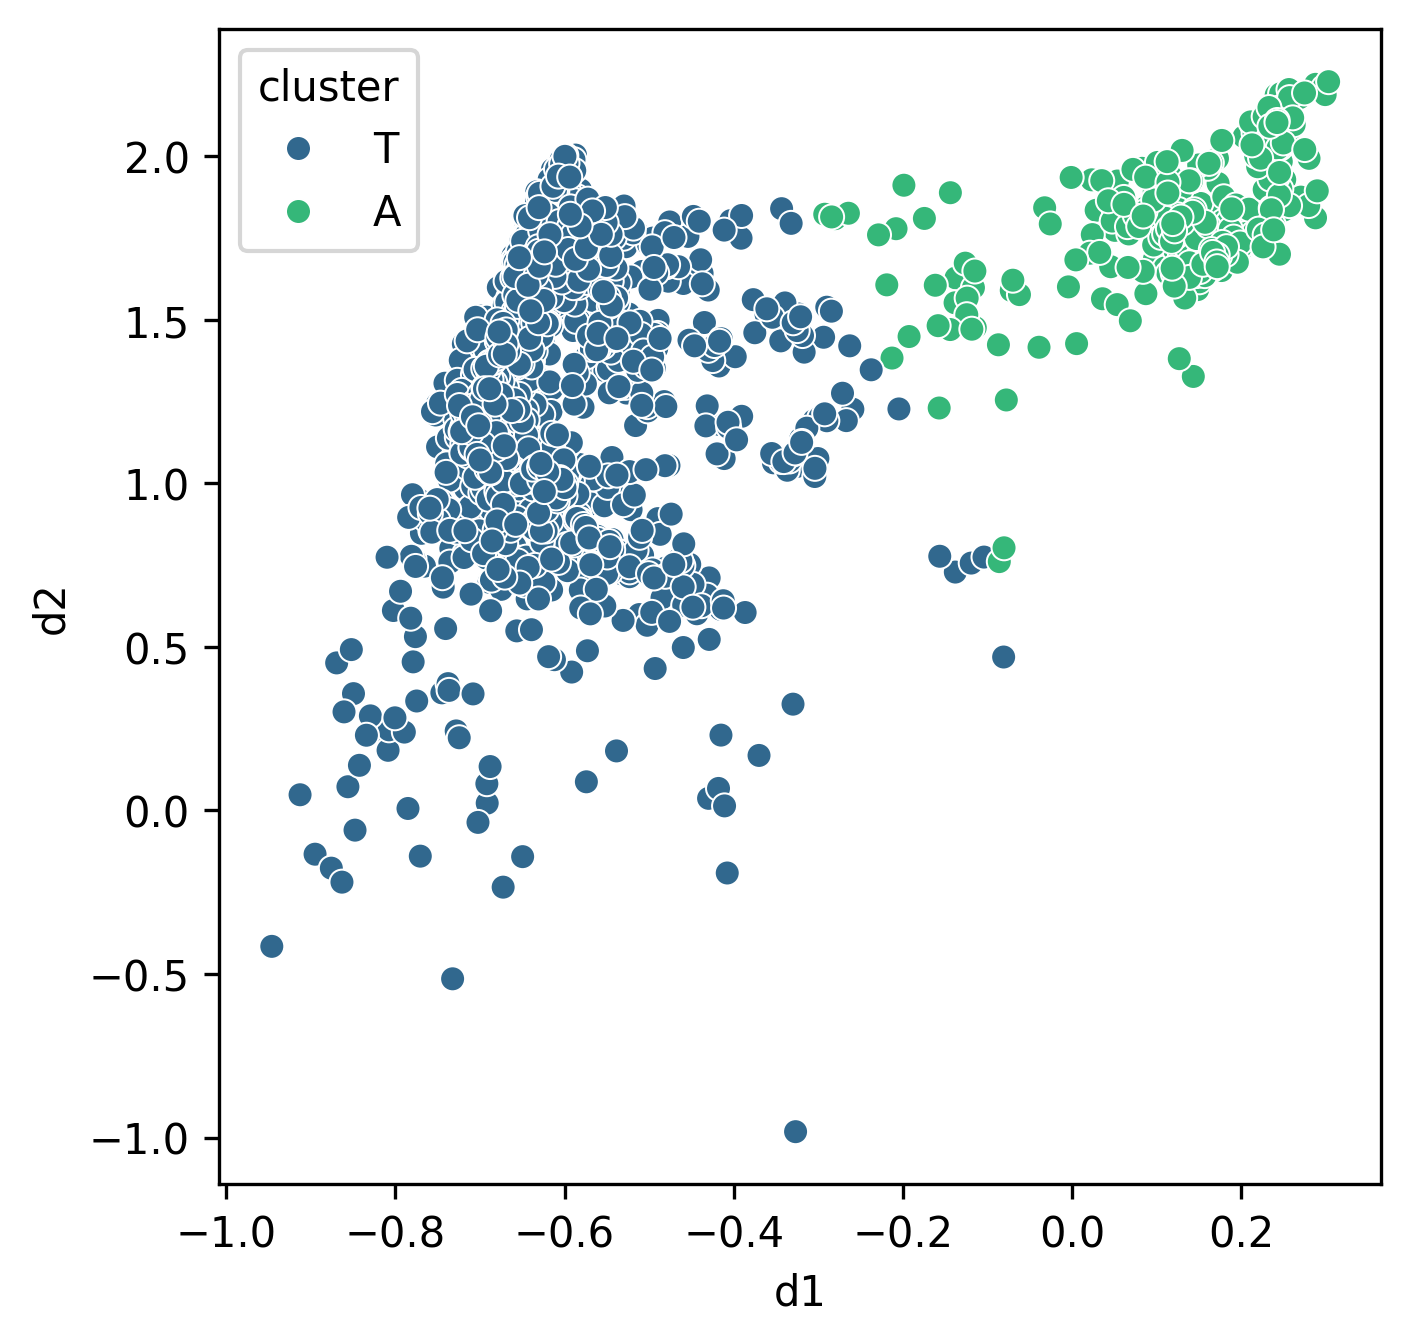

In [8]:
# A_idx = [1]
# T_idx = [0,2,4]
# M_idx = [3]
A_idx = [1]
T_idx = [0]

cluster_dict = {}
for idx in A_idx:
    cluster_dict[idx] = 'A'
for idx in T_idx:
    cluster_dict[idx] = 'T'
# for idx in M_idx:
#     cluster_dict[idx] = 'M'

t0_df['cluster'] = t0_df['cluster'].map(cluster_dict)
fig = plt.figure(figsize=(5, 5), dpi=300)
sns.scatterplot(data=t0_df, x='d1', y='d2', hue='cluster', palette='viridis');


In [9]:
# Get t0_df points as numpy array for distance calculation
t0_points = t0_df[['d1', 'd2']].values
# Calculate pairwise distances between end points and t0 points
distances = np.sqrt(((last_pt[:, None, :] - t0_points[None, :, :]) ** 2).sum(axis=2))
# Find index of nearest t0 point for each end point
nearest_indices = distances.argmin(axis=1)
# Get corresponding clusters
end_point_clusters = t0_df['cluster'].values[nearest_indices]


<Axes: >

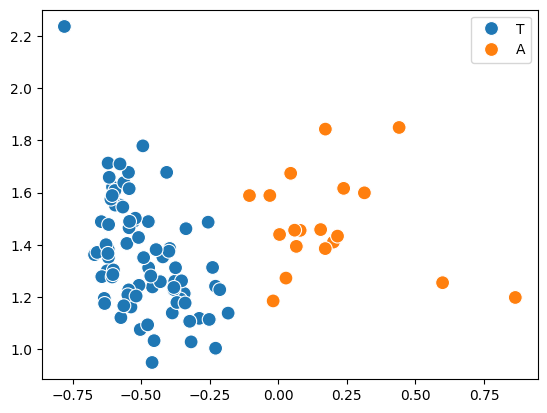

In [10]:
sns.scatterplot(x=last_pt[:, 0], y=last_pt[:, 1], hue=end_point_clusters, s=100, alpha=1)

In [11]:
traj_A = traj[:,end_point_clusters=='A',:]
traj_T = traj[:,end_point_clusters=='T',:]
# traj_M = traj[:,end_point_clusters=='M',:]

In [12]:
traj_A.shape

(100, 19, 2)

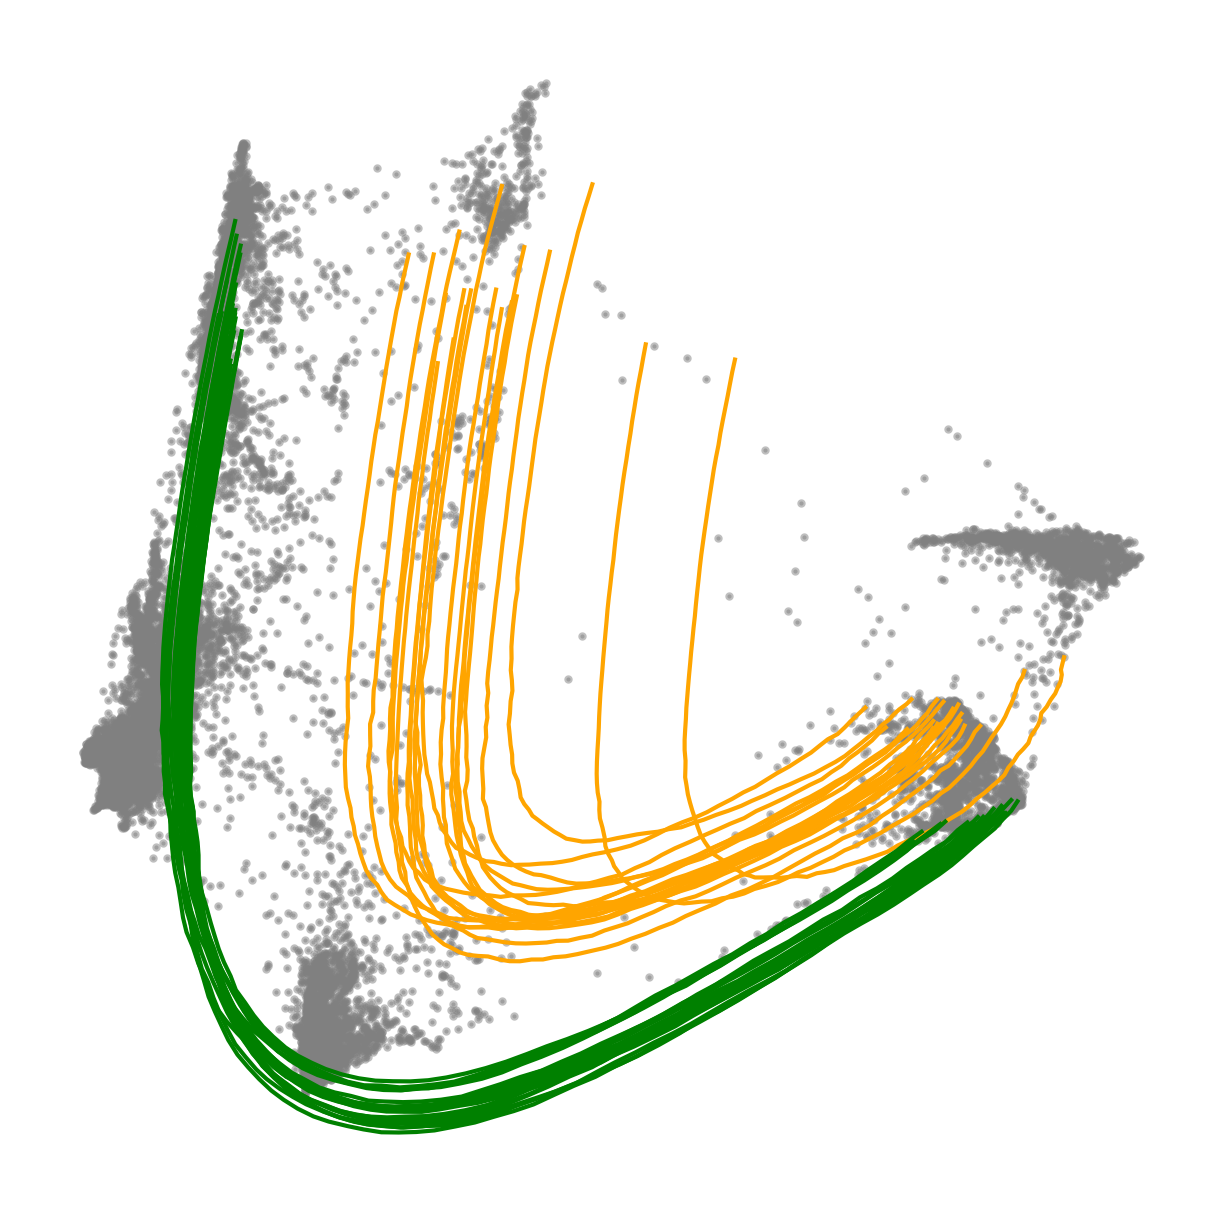

In [13]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(X_phate[:, 0], X_phate[:, 1],
                c='gray', s=1, alpha=0.5)

# np.random.seed(0)
# subsampled_idx = np.random.choice(traj_A.shape[1], 10, replace=False)
# subsampled_idx = np.arange(traj_A.shape[1])
subsampled_idx = np.argsort(traj_A[-1,:,0])[-20:]
for j in subsampled_idx:
    # Use the width array to determine the linewidths for this trajectory
    traj0 = traj_A[:,j,:]
    plt.plot(traj0[:, 0], traj0[:, 1], alpha=1, linewidth=1, color='orange');

# subsampled_idx = np.arange(traj_T.shape[1])
subsampled_idx = np.argsort(traj_T[-1,:,0])[1:20+1]
for j in subsampled_idx:
    # Use the width array to determine the linewidths for this trajectory
    traj0 = traj_T[:,j,:]
    plt.plot(traj0[:, 0], traj0[:, 1], alpha=1, linewidth=1, color='green');

# subsampled_idx = np.arange(traj_M.shape[1])
# for j in subsampled_idx:
#     # Use the width array to determine the linewidths for this trajectory
#     traj0 = traj_M[:,j,:]
#     plt.plot(traj0[:, 0], traj0[:, 1], alpha=1, linewidth=1, color='blue');





# remove ticks
plt.xticks([])
plt.yticks([])

# remove plot box
plt.axis('off')

# plt.savefig(f'{fig_path}/figure_5Ca.png', bbox_inches='tight')
plt.show()


In [14]:
subsampled_idx = np.argsort(traj_A[-1,:,0])[-20:]
traj_A_extreme = traj_A[:,subsampled_idx,:]
np.save(f'{res_dir}/trajectories_A_extreme.npy', traj_A_extreme)
subsampled_idx = np.argsort(traj_T[-1,:,0])[1:20+1]
traj_T_extreme = traj_T[:,subsampled_idx,:]
np.save(f'{res_dir}/trajectories_T_extreme.npy', traj_T_extreme)
# np.save(f'{res_dir}/trajectories_M.npy', traj_M)

